In [45]:
import csv
import numpy as np
import datetime
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
# Convert Data
def csv_row(row):
    return [int(row['query_id']), int(row[' timestamp'])]

with open('forecast_data/query_trace.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    i = 0
    data = np.array([[int(r['query_id']), int(r[' timestamp'])] for r in reader])

In [5]:
data = np.array(data)
type(data)

numpy.ndarray

In [6]:
sec = data[0][1]/1000

In [7]:
TRACE_START_TS_MS = data[0][1]
TRACE_END_TS_MS = data[-1][1]
TRACE_NUM_SAMPLE = len(data)

In [10]:
    def stat_util():
        print(f"{TRACE_NUM_SAMPLE} samples from {TRACE_START_TS_MS} to {TRACE_END_TS_MS}\n"
              f"{(TRACE_END_TS_MS - TRACE_START_TS_MS) / 1000000}seconds"
             )

In [11]:
stat_util()

3346047 samples from 3872921941324 to 3872991708946
69.767622seconds


In [20]:
def bucket(data:np.ndarray, interval:int = 1000000) -> Optional[np.ndarray]:
    """
    Bucket the timeseries data into another timeseries with each bucket having a fixed interval. 
    
    :param: interval number of ms in an interval 
    :data: 2D array where each row is of [query_id, timestamp]
    
    :return: 1D array timeseries data
    
    """
    TS_IDX = 1
    if len(data) <= 0:
        return None
    
    
    start_t = data[0][TS_IDX]
    end_t = data[-1][TS_IDX]
    
    if end_t - start_t <= 1:
        return None

    # Number of data points 
    num_buckets = (end_t - start_t -1) // interval + 1
    
    new_data = np.zeros(num_buckets)
    
    for i in range(len(data)):
        t = data[i][TS_IDX]
        bi = (t - start_t) // interval 
        
        new_data[bi]+=1
        
    
    return new_data

In [67]:
interval_ms = 500000

# Number of data points per sequence 
SEQ_LEN = 10 * MS_PER_SEC // interval_ms

TEST_DATA_SIZE = SEQ_LEN
bucket_data = bucket(data, interval_ms)
train_raw_data = bucket_data[:-TEST_DATA_SIZE]
test_raw_data = bucket_data[-TEST_DATA_SIZE:]

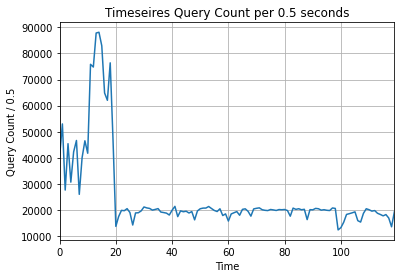

In [68]:
def plot_ts(data: np.ndarray, interval: int)->None:
    MS_PER_SEC = 1000000
    interval_sec = interval_ms / MS_PER_SEC
    plt.title(f'Timeseires Query Count per {interval_sec} seconds')
    plt.ylabel(f'Query Count / {interval_sec}')
    plt.xlabel('Time')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(data)
    
plot_ts(train_raw_data, interval_ms)

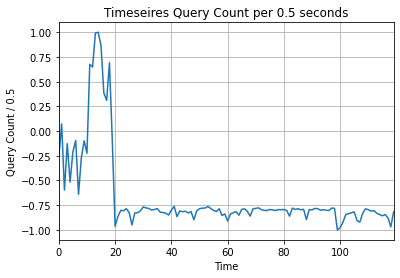

In [69]:
# Preprocess the data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(train_raw_data.reshape(-1, 1))

plot_ts(scaled_data, interval_ms)


In [70]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [71]:
# Start the training 
train_data = torch.FloatTensor(scaled_data).view(-1)




def create_seqs(input_data: torch.Tensor, seq_len: int) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    seqs = []
    for i in range(len(input_data) - seq_len):
        seq = input_data[i:i+seq_len]
        label = input_data[i+seq_len: i+seq_len+1]
        
        seqs.append((seq, label))
        
    return seqs

train_seqs = create_seqs(train_data, SEQ_LEN)

# Training specifics 
model = LSTM()
loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 150
for i in range(epochs):
    for seq, labels in train_seqs:
        optimizer.zero_grad()
        
        # FIXME(ricky): is this the best-practice?
        # Reset the hidden cells 
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00016888
epoch:  26 loss: 0.00004653
epoch:  51 loss: 0.00313219
epoch:  76 loss: 0.00928669
epoch: 101 loss: 0.00819625
epoch: 126 loss: 0.01276355
epoch: 149 loss: 0.0164297670


In [72]:
# Use the trained model for prediction 
fut_pred = SEQ_LEN

# The last SEQ_LEN data points for out-of-sample prediction 
test_inputs = train_data[-SEQ_LEN:].tolist()

model.eval()

for i in range(SEQ_LEN): 
    seq = torch.FloatTensor(test_inputs[-SEQ_LEN:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
actual_predictions = scaler.inverse_transform(np.array(test_inputs[SEQ_LEN:] ).reshape(-1, 1))

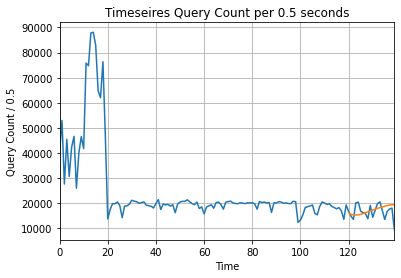

In [73]:
# Plot the prediction 
pred_x = np.arange(len(train_raw_data), len(train_raw_data) + TEST_DATA_SIZE, 1)

plot_ts(bucket_data, interval_ms)
plt.plot(pred_x, actual_predictions)
plt.show()